In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dlib
import cv2
import os
import imutils
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay
from sklearn.ensemble import RandomForestClassifier
import math
from sklearn.ensemble import AdaBoostClassifier

In [2]:
faceCascade = cv2.CascadeClassifier("/Users/lucy/Projects/opencv-master/data/haarcascades/haarcascade_frontalface_default.xml")  
predictor = dlib.shape_predictor("/Users/lucy/Desktop/Graduate School/ICSI 531 - Data Mining/Project/code/shape_predictor_68_face_landmarks.dat")  

## 1. Preprocessing CSV file

In [73]:
# Load training set
train = pd.read_csv('train.csv')
train.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [67]:
# Load whole dataset
whole = pd.read_csv('icml_face_data.csv')
whole.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [80]:
# Extract testing set
test = pd.concat([whole[whole[' Usage'] == 'PublicTest'], whole[whole[' Usage'] == 'PrivateTest']])
test = test.drop(columns=[' Usage'])
test = test.rename(columns = {' pixels':'pixels'})
test.head()

,emotion,pixels
28709,0,254 254 254 254 254 249 255 160 2 58 53 70 77 ...
28710,1,156 184 198 202 204 207 210 212 213 214 215 21...
28711,4,69 118 61 60 96 121 103 87 103 88 70 90 115 12...
28712,6,205 203 236 157 83 158 120 116 94 86 155 180 2...
28713,3,87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...


In [104]:
# Convert pixels to a matrix
def str_mat(data):
    pixels = data.loc[:, "pixels"]
    matrix = np.empty([pixels.shape[0], 2304])
    for i in data.index:
        one_sample = np.array([int(p) for p in pixels[i].split()])
        matrix[i-data.index[0]] = one_sample
    return matrix

In [106]:
Xtr = str_mat(train)
ytr = train.loc[:, "emotion"]
print(Xtr.shape, ytr.shape)

(28709, 2304) (28709,)


In [107]:
Xte = str_mat(test)
yte = test.loc[:, "emotion"]
print(Xte.shape, yte.shape)

(7178, 2304) (7178,)


### cf) to Image

In [9]:
# # pixels to image
# def pix_img(idx, matrix):
#     face = matrix[idx].reshape(48,48)
#     plt.imshow(face)

In [10]:
# pix_img(1, X)

### cf) Simple Face Detection with HoG

In [11]:
# #step1: read the image
# image = cv2.imread("test_image.jpg")

# #step2: converts to gray image
# gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# #step3: get HOG face detector and faces
# hogFaceDetector = dlib.get_frontal_face_detector()
# faces = hogFaceDetector(gray, 1)

# #step4: loop through each face and draw a rect around it
# for (i, rect) in enumerate(faces):
#     x = rect.left()
#     y = rect.top()
#     w = rect.right() - x
#     h = rect.bottom() - y
#     #draw a rectangle
#     cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
# #step5: display the resulted image
# cv2.imshow("Image", image)
# cv2.waitKey(0); 
# cv2.destroyAllWindows(); 
# cv2.waitKey(1)

### cf) Feature Detection and Extraction

In [12]:
# # Read the image  
# # image = cv2.imread("IMG_4733 Medium.jpeg")
# image = cv2.imread("test_image.jpg")
# gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [13]:
# # Detect faces in the image  
# faces = faceCascade.detectMultiScale(  
#   gray,  
#   scaleFactor=1.05,  
#   minNeighbors=5,  
#   minSize=(10, 10),  
#   flags=cv2.CASCADE_SCALE_IMAGE  
# )  

# print("Found {0} faces!".format(len(faces)))  

#### - Detect selected features

In [14]:
# # Group each features
# JAWLINE_POINTS = list(range(0, 17))  
# RIGHT_EYEBROW_POINTS = list(range(17, 22))  
# LEFT_EYEBROW_POINTS = list(range(22, 27))  
# NOSE_POINTS = list(range(27, 36))  
# RIGHT_EYE_POINTS = list(range(36, 42))  
# LEFT_EYE_POINTS = list(range(42, 48))  
# MOUTH_OUTLINE_POINTS = list(range(48, 61))  
# MOUTH_INNER_POINTS = list(range(61, 68))  

In [15]:
# # Draw a rectangle around the faces  
# for (x, y, w, h) in faces:  
#     cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)  
#     # Converting the OpenCV rectangle coordinates to Dlib rectangle  
#     dlib_rect = dlib.rectangle(int(x), int(y), int(x + w), int(y + h))  

#     landmarks = np.matrix([[p.x, p.y] for p in predictor(image, dlib_rect).parts()])  
#     # Select area
#     landmarks_display = landmarks[RIGHT_EYE_POINTS + LEFT_EYE_POINTS]  

#     for idx, point in enumerate(landmarks_display):  
#         pos = (point[0, 0], point[0, 1])  
#         selected_image = cv2.circle(image, pos, 2, color=(0, 255, 255), thickness=-1)  

# cv2.imshow("Selected features", image)  
# cv2.waitKey(0)  
# cv2.destroyAllWindows(); 
# cv2.waitKey(1)

#### - Detect all features

In [16]:
# # Draw a rectangle around the faces  
# for (x, y, w, h) in faces:  
#   cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)  
  
#   # Converting the OpenCV rectangle coordinates to Dlib rectangle  
#   dlib_rect = dlib.rectangle(int(x), int(y), int(x + w), int(y + h))  
  
#   landmarks = np.matrix([[p.x, p.y]  
#               for p in predictor(image, dlib_rect).parts()])  
  
#   for idx, point in enumerate(landmarks):  
#     pos = (point[0, 0], point[0, 1])  
#     cv2.putText(image, str(idx), pos,  
#           fontFace=cv2.FONT_HERSHEY_SCRIPT_SIMPLEX,  
#           fontScale=0.4ƒ,  
#           color=(0, 0, 255))  
  
#     cv2.circle(image, pos, 2, color=(0, 255, 255), thickness=-1)  
  
# cv2.imshow("Landmarks found", image)  
# cv2.waitKey(0); 
# cv2.destroyAllWindows(); 
# cv2.waitKey(1)

## 2. Feature Matrix

#### - Helper functions

In [108]:
def save_temp(idx, matrix):
    # face = matrix[idx].reshape(48,48)
    # plt.imsave("temp"+str(idx)+".jpg", face)

    cv2.imwrite("temp"+str(idx)+".jpg", np.reshape(matrix[idx], (48,48)))
    image = cv2.imread("temp"+str(idx)+".jpg")
    image = imutils.resize(image, width=500)

def delete_temp(img_name):
    os.remove(img_name)

def feature_vec(my_image, my_faces):
    my_landmarks = []
    for (x, y, w, h) in my_faces:  
        cv2.rectangle(my_image, (x, y), (x + w, y + h), (0, 255, 0), 2)  
        # Converting the OpenCV rectangle coordinates to Dlib rectangle  
        dlib_rect = dlib.rectangle(int(x), int(y), int(x + w), int(y + h))  
        my_landmarks = np.matrix([[p.x, p.y] for p in predictor(my_image, dlib_rect).parts()])  
    return my_landmarks

#### - Convert Xtr into a featrue matrix

In [109]:
# Initialize
Xtr_features = np.zeros((Xtr.shape[0], 68*2))
face_detected_tr = []
face_not_detected_tr = []

for i in range(Xtr.shape[0]):
    # Save image
    save_temp(i, Xtr)

    # Read the image  
    temp_image = cv2.imread("temp"+str(i)+".jpg")
    # temp_gray = cv2.cvtColor(temp_image, cv2.COLOR_BGR2GRAY)

    # Detect faces in the image  
    temp_faces = faceCascade.detectMultiScale(  
    temp_image,  
    scaleFactor=1.05,  
    minNeighbors=4,  
    minSize=(10, 10),  
    flags=cv2.CASCADE_SCALE_IMAGE)
    # print("Found {0} faces!".format(len(temp_faces)))  

    # # Show detected face
    # for (x, y, w, h) in temp_faces:
    #     cv2.rectangle(temp_image, (x, y), (x+w, y+h), (255, 0, 0), 2)
    # cv2.imshow('Window Title', temp_image)
    # cv2.waitKey(0); 
    # cv2.destroyAllWindows(); 
    # cv2.waitKey(1)

    # Get landmarks
    if len(temp_faces) > 0:
        # Get landmarks
        landmarks = np.array(feature_vec(temp_image, temp_faces))
        face_detected_tr.append(i)
    else:
        landmarks = np.zeros((1, 136))
        face_not_detected_tr.append(i)

    # Store landmarks
    Xtr_features[i] = landmarks.flatten()

    # Delete image
    delete_temp("temp"+str(i)+".jpg")

print(len(face_detected_tr), "faces detected, ", len(face_not_detected_tr), "faces not detected.")

13607 faces detected,  15102 faces not detected.


#### - Drop face non-detected data

In [111]:
Xtr_features = Xtr_features[face_detected_tr]
ytr = np.array(ytr)
ytr = ytr[face_detected_tr]

#### - Convert Xte into a featrue matrix

In [112]:
# Initialize
Xte_features = np.zeros((Xte.shape[0], 68*2))
face_detected_te = []
face_not_detected_te = []

for i in range(Xte.shape[0]):
    # Save image
    save_temp(i, Xte)

    # Read the image  
    temp_image = cv2.imread("temp"+str(i)+".jpg")
    # temp_gray = cv2.cvtColor(temp_image, cv2.COLOR_BGR2GRAY)

    # Detect faces in the image  
    temp_faces = faceCascade.detectMultiScale(  
    temp_image,  
    scaleFactor=1.05,  
    minNeighbors=4,  
    minSize=(10, 10),  
    flags=cv2.CASCADE_SCALE_IMAGE)

    # Get landmarks
    if len(temp_faces) > 0:
        # Get landmarks
        landmarks = np.array(feature_vec(temp_image, temp_faces))
        face_detected_te.append(i)
    else:
        landmarks = np.zeros((1, 136))
        face_not_detected_te.append(i)

    # Store landmarks
    Xte_features[i] = landmarks.flatten()

    # Delete image
    delete_temp("temp"+str(i)+".jpg")

print(len(face_detected_te), "faces detected, ", len(face_not_detected_te), "faces not detected.")

3433 faces detected,  3745 faces not detected.


#### - Drop face non-detected data

In [113]:
Xte_features = Xte_features[face_detected_te]
yte = np.array(yte)
yte = yte[face_detected_te]

## 3. Distance Matrix

#### - Helper functions

In [114]:
# Dawson's landmarks[a][b] = Here feature_matrix[2*a+b]
def feature_distance(feature_matrix):
    distance_matrix = np.zeros((feature_matrix.shape[0], 18))
    for i in range(feature_matrix.shape[0]):
        distances = []
        # right_eye_height
        distances.append(feature_matrix[i][83] - feature_matrix[i][75] + feature_matrix[i][81] - feature_matrix[i][77])
        # left_eye_height
        distances.append(feature_matrix[i][95] - feature_matrix[i][87] + feature_matrix[i][93] - feature_matrix[i][89])
        # right_eye_width
        distances.append(feature_matrix[i][78] - feature_matrix[i][72])
        # left_eye_width
        distances.append(feature_matrix[i][90] - feature_matrix[i][84])
        # left_eyebrow_width
        distances.append(feature_matrix[i][42] - feature_matrix[i][34])
        # right_eyebrow_width
        distances.append(feature_matrix[i][52] - feature_matrix[i][44])
        # right_eyebrow_eye_distance
        distances.append((feature_matrix[i][75] - feature_matrix[i][39] + feature_matrix[i][77] - feature_matrix[i][41]) / 2)
        # left_eyebrow_eye_distance
        distances.append((feature_matrix[i][87] - feature_matrix[i][47] + feature_matrix[i][89] - feature_matrix[i][49]) / 2)
        # mouth_gap
        distances.append((feature_matrix[i][135] + feature_matrix[i][133] + feature_matrix[i][131] - feature_matrix[i][125] - feature_matrix[i][123] - feature_matrix[i][127])/3)
        # mouth_height_center_avg
        distances.append((feature_matrix[i][117] + feature_matrix[i][115] + feature_matrix[i][113] - feature_matrix[i][101] - feature_matrix[i][103] - feature_matrix[i][105])/3)
        # mouth_height_left_avg
        distances.append((feature_matrix[i][119] + feature_matrix[i][117] + feature_matrix[i][115] - feature_matrix[i][99] - feature_matrix[i][101] - feature_matrix[i][103])/3)
        # mouth_height_right_avg
        distances.append((feature_matrix[i][115] + feature_matrix[i][113] + feature_matrix[i][111] - feature_matrix[i][103] - feature_matrix[i][105] - feature_matrix[i][107])/3)
        # mouth_height_centerline_toplip
        distances.append((feature_matrix[i][97] + feature_matrix[i][109])/2 - feature_matrix[i][103])
        # mouth_height_centerline_bottomlip
        distances.append(feature_matrix[i][115] - (feature_matrix[i][97] + feature_matrix[i][109])/2)
        # lip_width
        distances.append(feature_matrix[i][108] - feature_matrix[i][96])
        # distance_between_nose_toplip
        distances.append(feature_matrix[i][103] - feature_matrix[i][67])
        # distance_between_left_eye_corner_left_lip_corner
        lell = np.array([feature_matrix[i][96] - feature_matrix[i][72], feature_matrix[i][97] - feature_matrix[i][73]])
        distances.append((lell[0]**2 + lell[1]**2)**(1/2))
        # distance_between_right_eye_corner_right_lip_corner
        rerl = np.array([feature_matrix[i][90] - feature_matrix[i][108], feature_matrix[i][109] - feature_matrix[i][91]])
        distances.append((rerl[0]**2 + rerl[1]**2)**(1/2))
        # Add to the matrix
        distance_matrix[i] = np.array(distances)
    return distance_matrix

#### - Drop face non-detected data

In [115]:
Xtr_distances = feature_distance(Xtr_features)
Xte_distances = feature_distance(Xte_features)

## 4. LightGBM

### 1) Using raw coordinates

In [116]:
lightGBM = lgb.LGBMClassifier(random_state=0)
lightGBM.fit(Xtr_features, ytr)
ypr_lgbm = lightGBM.predict(Xte_features)
# Check accuracy
print('LightGBM using raw coordinates: {0:0.4f}'.format(accuracy_score(yte, ypr_lgbm)))

LightGBM using raw coordinates: 0.5517


### 2) Using distances

In [117]:
lightGBM2 = lgb.LGBMClassifier(random_state=0)
lightGBM2.fit(Xtr_distances, ytr)
ypr_lgbm2 = lightGBM2.predict(Xte_distances)
# Check accuracy
print('LightGBM using distances: {0:0.4f}'.format(accuracy_score(yte, ypr_lgbm2)))

LightGBM using distances: 0.5456


## 5. Random Forest

In [127]:
def configurations_RF(depths):
    accuracies = []
    for d in depths:
        randomForest = RandomForestClassifier(max_depth=d, random_state=0)
        randomForest.fit(Xtr_features, ytr)
        ypr_rf = randomForest.predict(Xte_features)
        accuracies.append(accuracy_score(yte, ypr_rf))
    return accuracies

In [136]:
configurations_RF([15, 16, 17, 18, 19, 20])

[0.5345179143606176,
 0.5356830760267988,
 0.5394698514418875,
 0.5400524322749781,
 0.5429653364404311,
 0.533935333527527]

### 1) Using raw coordinates

In [137]:
randomForest = RandomForestClassifier(max_depth=19, random_state=0)
randomForest.fit(Xtr_features, ytr)
ypr_rf = randomForest.predict(Xte_features)
# Check accuracy
print('RF using raw coordinates: {0:0.4f}'.format(accuracy_score(yte, ypr_rf)))

RF using raw coordinates: 0.5430


### 2) Using distances

In [138]:
randomForest2 = RandomForestClassifier(max_depth=19, random_state=0)
randomForest2.fit(Xtr_distances, ytr)
ypr_rf2 = randomForest2.predict(Xte_distances)
# Check accuracy
print('RF using distances: {0:0.4f}'.format(accuracy_score(yte, ypr_rf2)))

RF using distances: 0.5575


## 6. AdaBoost

In [146]:
def configurations_ADA(estimators):
    accuracies = []
    for d in estimators:
        adaBoost = AdaBoostClassifier(n_estimators=d, random_state=0)
        adaBoost.fit(Xtr_features, ytr)
        ypr_ada = adaBoost.predict(Xte_features)    
        accuracies.append(accuracy_score(yte, ypr_ada))
    return accuracies

In [147]:
configurations_ADA([50, 75, 100, 125, 150])

[0.4500436935624818,
 0.4503349839790271,
 0.4593649868919313,
 0.4616953102242936,
 0.4587824060588407]

### 1) Using raw coordinates

In [148]:
adaBoost = AdaBoostClassifier(n_estimators=125, random_state=0)
adaBoost.fit(Xtr_features, ytr)
ypr_ada = adaBoost.predict(Xte_features)
# Check accuracy
print('AdaBoost using raw coordinates: {0:0.4f}'.format(accuracy_score(yte, ypr_ada)))

AdaBoost using raw coordinates: 0.4617


### 2) Using distances

In [149]:
adaBoost2 = AdaBoostClassifier(n_estimators=125, random_state=0)
adaBoost2.fit(Xtr_distances, ytr)
ypr_ada2 = adaBoost2.predict(Xte_distances)
# Check accuracy
print('AdaBoost using distances: {0:0.4f}'.format(accuracy_score(yte, ypr_ada2)))

AdaBoost using distances: 0.4850


## 7. ROC curve

In [122]:
# Binarize
def binarize(model, tr_features, te_features, y_tr, y_te):
    label_binarizer = LabelBinarizer().fit(y_tr)
    y_onehot_test = label_binarizer.transform(y_te)
    y_score = model.fit(tr_features, ytr).predict_proba(te_features)
    return y_onehot_test, y_score

# Plot ROC curve
def roc_curve(models, onehot_tests, scores):
    # plotting parameters
    cols = 3
    linewidth = 1
    rows = math.ceil(7 / cols)
    emotions = {0:'angry', 1:'disgust', 2:'fear', 3:'happy', 4:'sad', 5:'surprise', 6:'neutral'}

    fig, axs = plt.subplots(rows, cols, figsize=(15, rows*6))
    model_names = {0:'LightGBM', 1:'RF', 2:'Ada'}

    for i in range(7):
        emotion_name = emotions[i]
        for m in range(len(models)):
            model_name = model_names[m]
            display = RocCurveDisplay.from_predictions(onehot_tests[m][:, i],
                                                       scores[m][:, i],
                                                       name=f"{model_name}",
                                                       linewidth=linewidth,
                                                       ax=axs[i // cols, i % cols],)

        axs[i // cols, i % cols].plot([0, 1], [0, 1], linewidth=linewidth, linestyle=":")
        axs[i // cols, i % cols].set_title(emotion_name)
        axs[i // cols, i % cols].set_xlabel("False Positive Rate")
        axs[i // cols, i % cols].set_ylabel("True Positive Rate")
    plt.tight_layout(pad=2.0)  # spacing between subplots
    plt.show()

### 1) Using raw coordinates

In [123]:
gbm_oh, gbm_sc = binarize(lightGBM, Xtr_features, Xte_features, ytr, yte)
rf_oh, rf_sc = binarize(randomForest, Xtr_features, Xte_features, ytr, yte)
ada_oh, ada_sc = binarize(adaBoost, Xtr_features, Xte_features, ytr, yte)

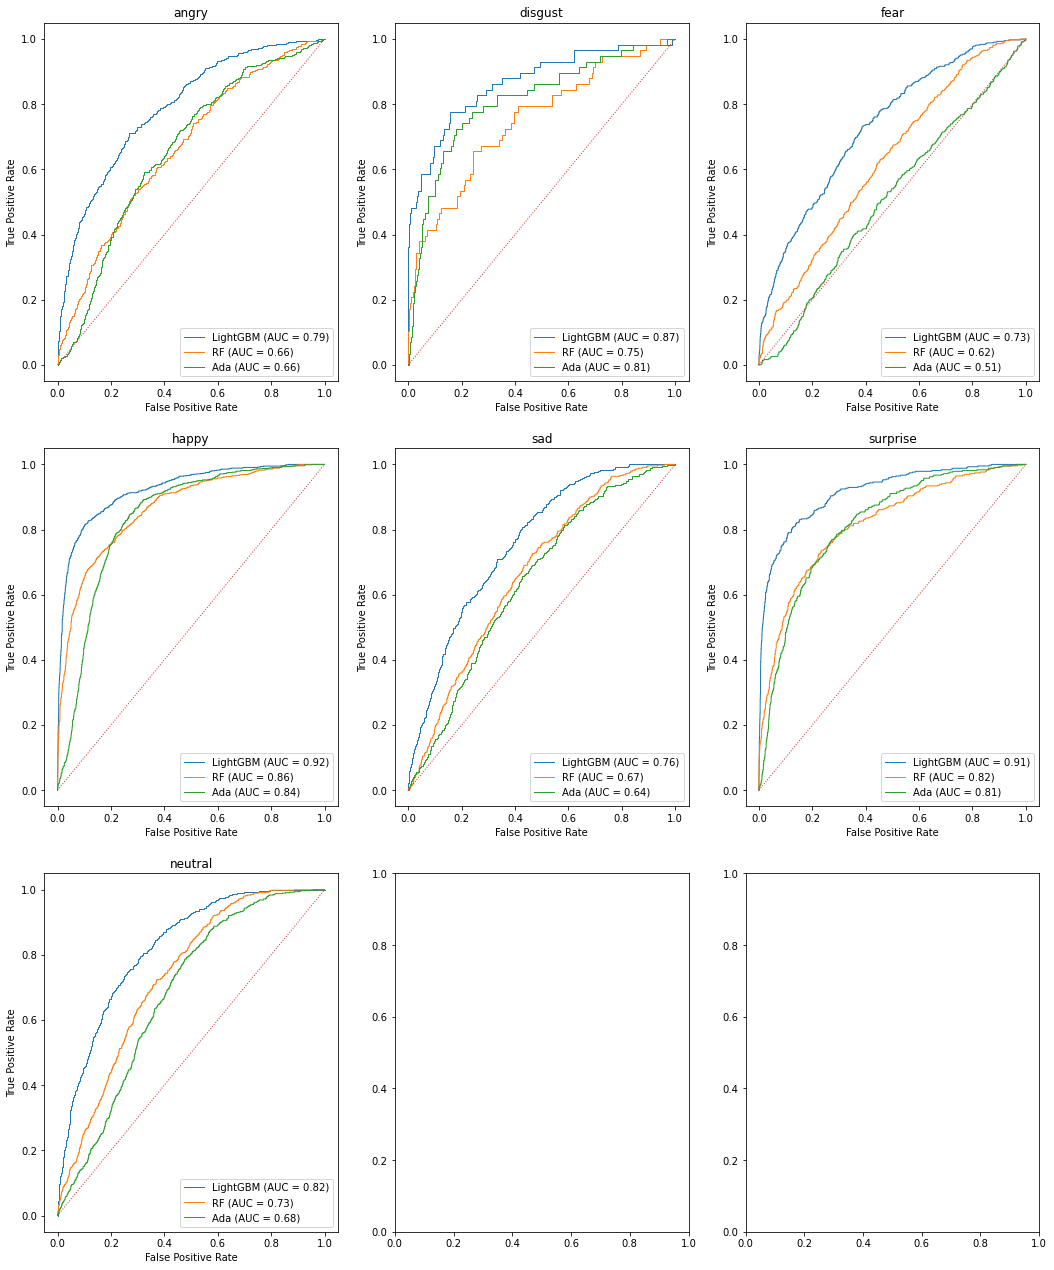

In [124]:
roc_curve([lightGBM, randomForest, adaBoost], [gbm_oh, rf_oh, ada_oh], [gbm_sc, rf_sc, ada_sc])

### 2) Using distances

In [125]:
gbm_oh2,gbm_sc2 = binarize(lightGBM2, Xtr_distances, Xte_distances, ytr, yte)
rf_oh2, rf_sc2 = binarize(randomForest2, Xtr_distances, Xte_distances, ytr, yte)
ada_oh2, ada_sc2 = binarize(adaBoost2, Xtr_distances, Xte_distances, ytr, yte)

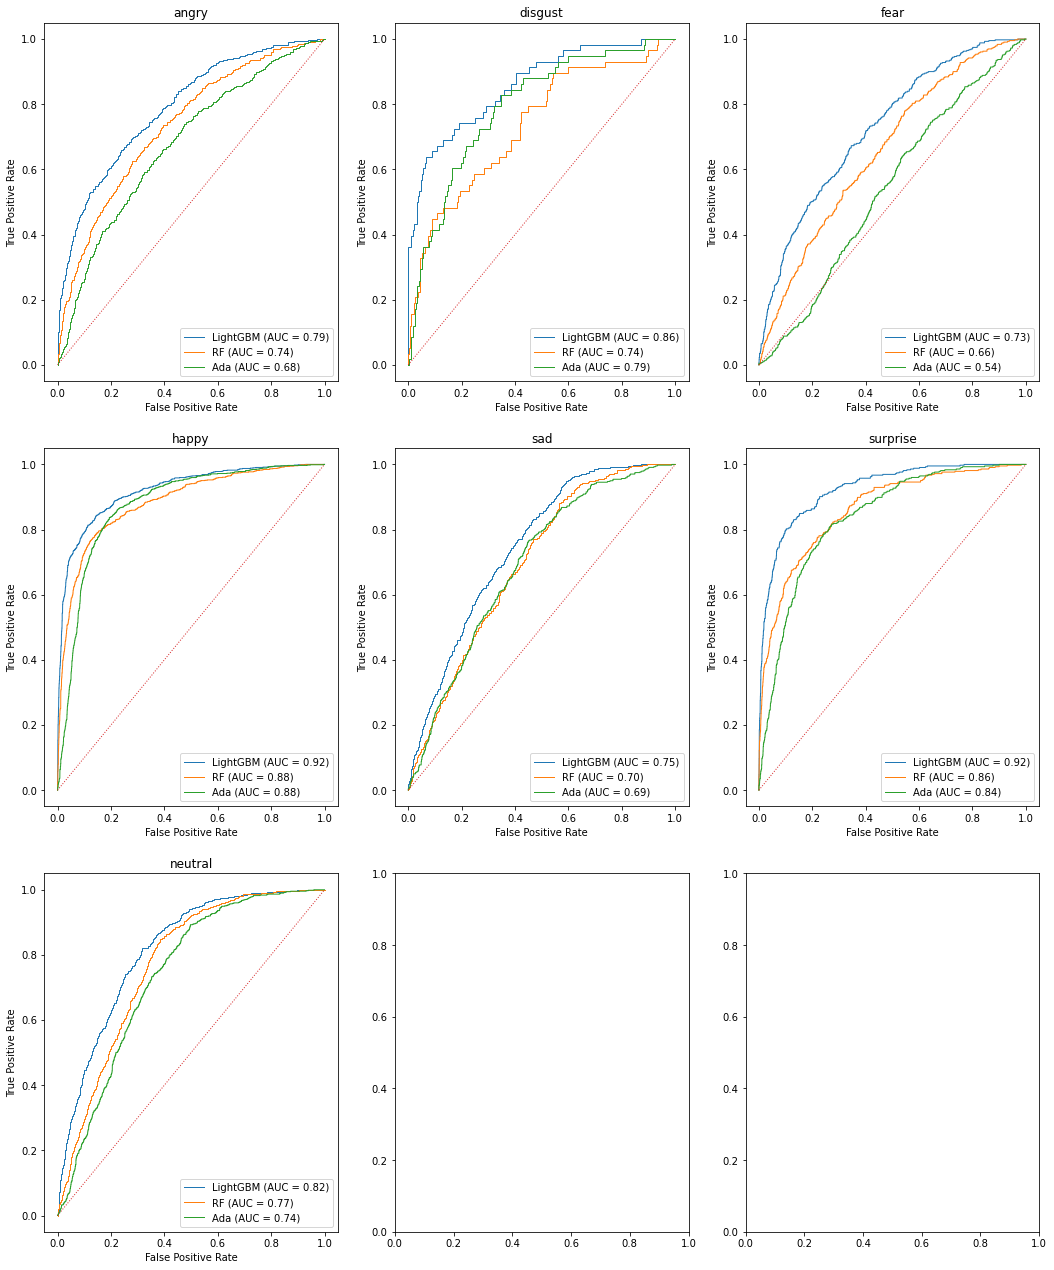

In [126]:
roc_curve([lightGBM2, randomForest2, adaBoost2], [gbm_oh2, rf_oh2, ada_oh2], [gbm_sc2, rf_sc2, ada_sc2])